# Density vs density-contrast

## import packages

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

# local python scripts
from RIS_gravity_inversion import plotting, synthetic
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils

from antarctic_plots import utils, regions, maps, fetch, profile
import numpy as np
import pandas as pd
import xarray as xr
import verde as vd
import scipy as sp
import rioxarray
import harmonica as hm
import pygmt

## Get sample data

Ice surface and bed from Bedmap2

In [33]:
spacing = 1e3

inner_region = regions.minna_bluff  # [40e3, 100e3, -20e3, 20e3]
buffer_region = utils.alter_region(inner_region, buffer=100e3)[1]

surface = fetch.bedmap2(
    layer="surface",
    region=buffer_region,
    spacing=spacing,
    fill_nans=True,
    reference="ellipsoid",
)
icebase = fetch.bedmap2(
    layer="icebase",
    region=buffer_region,
    spacing=spacing,
    fill_nans=True,
    reference="ellipsoid",
)
bed = fetch.bedmap2(
    layer="bed",
    region=buffer_region,
    spacing=spacing,
    fill_nans=True,
    reference="ellipsoid",
)

converting to be referenced to the WGS84 ellipsoid
returning grid with new region and/or registration, same spacing
converting to be referenced to the WGS84 ellipsoid
returning grid with new region and/or registration, same spacing
converting to be referenced to the WGS84 ellipsoid
returning grid with new region and/or registration, same spacing


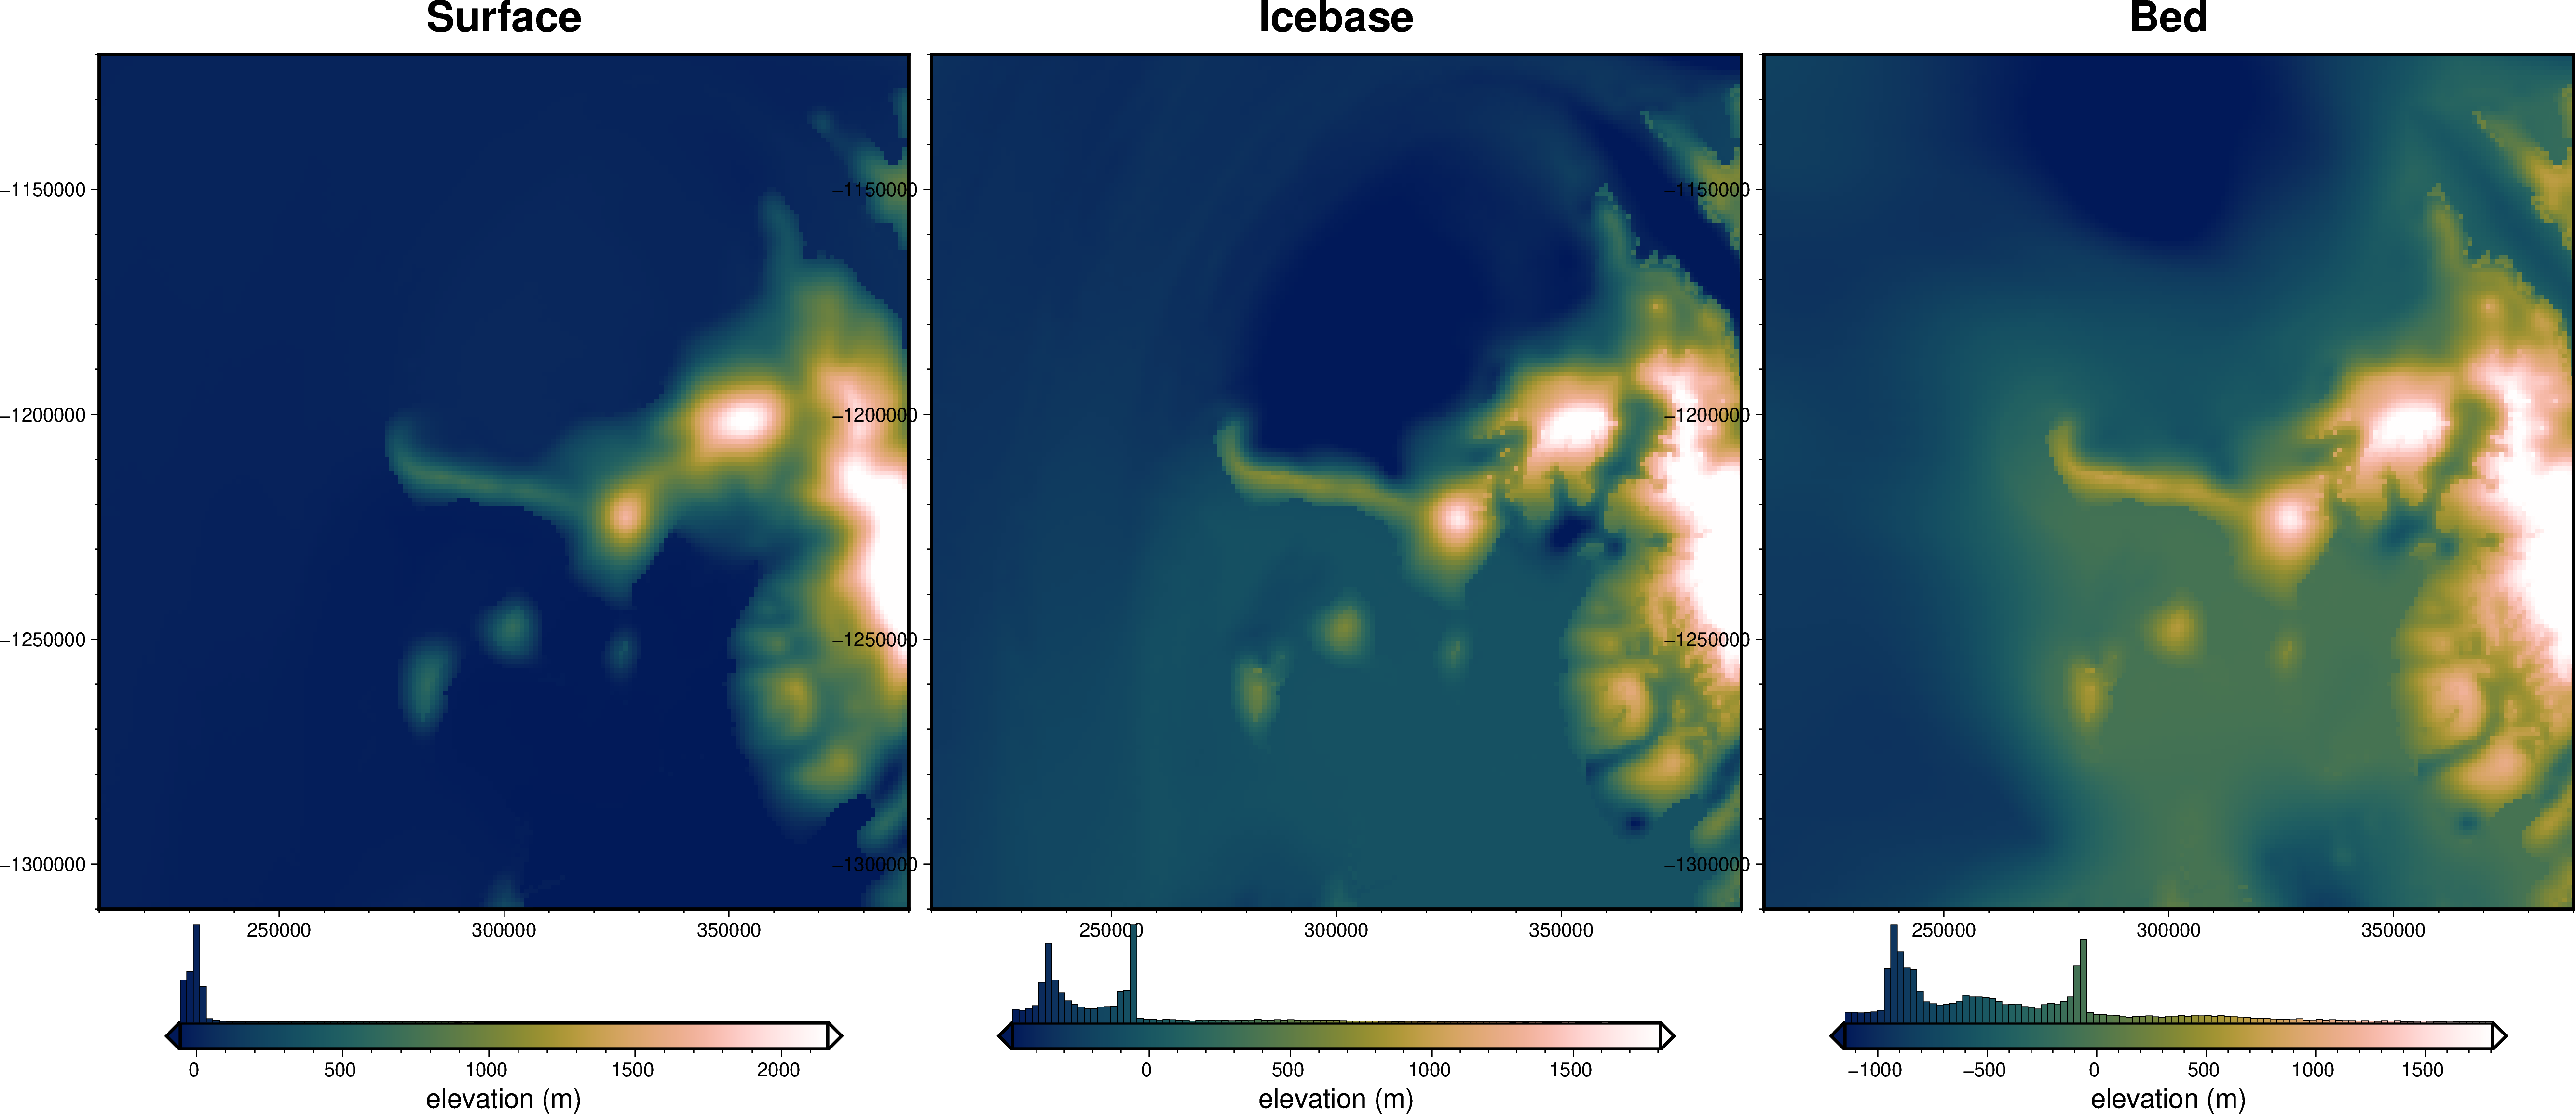

In [34]:
fig = maps.plot_grd(
    surface,
    inset=False,
    title="Surface",
    cbar_label="elevation (m)",
    # show_region=inner_region,
    region=inner_region,
    cmap="batlowW",
    hist=True,
    # shading=True,
    robust=True,
    frame=True,
)
fig = maps.plot_grd(
    icebase,
    inset=False,
    title="Icebase",
    cbar_label="elevation (m)",
    # show_region=inner_region,
    region=inner_region,
    cmap="batlowW",
    hist=True,
    # shading=True,
    robust=True,
    frame=True,
    fig=fig,
    origin_shift="xshift",
)
fig = maps.plot_grd(
    bed,
    inset=False,
    title="Bed",
    cbar_label="elevation (m)",
    # show_region=inner_region,
    region=inner_region,
    cmap="batlowW",
    hist=True,
    # shading=True,
    robust=True,
    frame=True,
    fig=fig,
    origin_shift="xshift",
)
fig.show()

In [35]:
utils.get_grid_info(surface)

(1000.0,
 [110000.0, 490000.0, -1410000.0, -1020000.0],
 -56.5244903564,
 3041.99487305,
 'g')

## create observation points

In [36]:
coords = vd.grid_coordinates(
    inner_region,
    spacing=spacing * 2,
    extra_coords=3e3,
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

# observations = fetch.resample_grid(observations, region=inversion_region, registration=registration)
print(utils.get_grid_info(observations))

observation_points = vd.grid_to_table(observations)
observation_points

(2000.0, [210000.0, 390000.0, -1310000.0, -1120000.0], 3000.0, 3000.0, 'g')


,northing,easting,upward
0,-1310000.0,210000.0,3000.0
1,-1310000.0,212000.0,3000.0
2,-1310000.0,214000.0,3000.0
3,-1310000.0,216000.0,3000.0
4,-1310000.0,218000.0,3000.0
...,...,...,...
8731,-1120000.0,382000.0,3000.0
8732,-1120000.0,384000.0,3000.0
8733,-1120000.0,386000.0,3000.0
8734,-1120000.0,388000.0,3000.0


# Absolute Densities

In [37]:
ice_prisms = inv_utils.grids_to_prisms(
    surface,
    icebase,
    density=917,
    input_coord_names=["x", "y"],
)

water_prisms = inv_utils.grids_to_prisms(
    icebase,
    bed,
    density=1030,
    input_coord_names=["x", "y"],
)

earth_prisms = inv_utils.grids_to_prisms(
    bed,
    np.nanmin(bed),
    density=2670,
    input_coord_names=["x", "y"],
)

# plotting.show_prism_layers(
#     [ice_prisms, bed_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     # color_by='constant',
#     clip_box=False,
#     zscale=20,
# )

  0%|                                                  | 0/8736 [00:00<?, ?it/s]

  0%|                                                  | 0/8736 [00:00<?, ?it/s]

  0%|                                                  | 0/8736 [00:00<?, ?it/s]

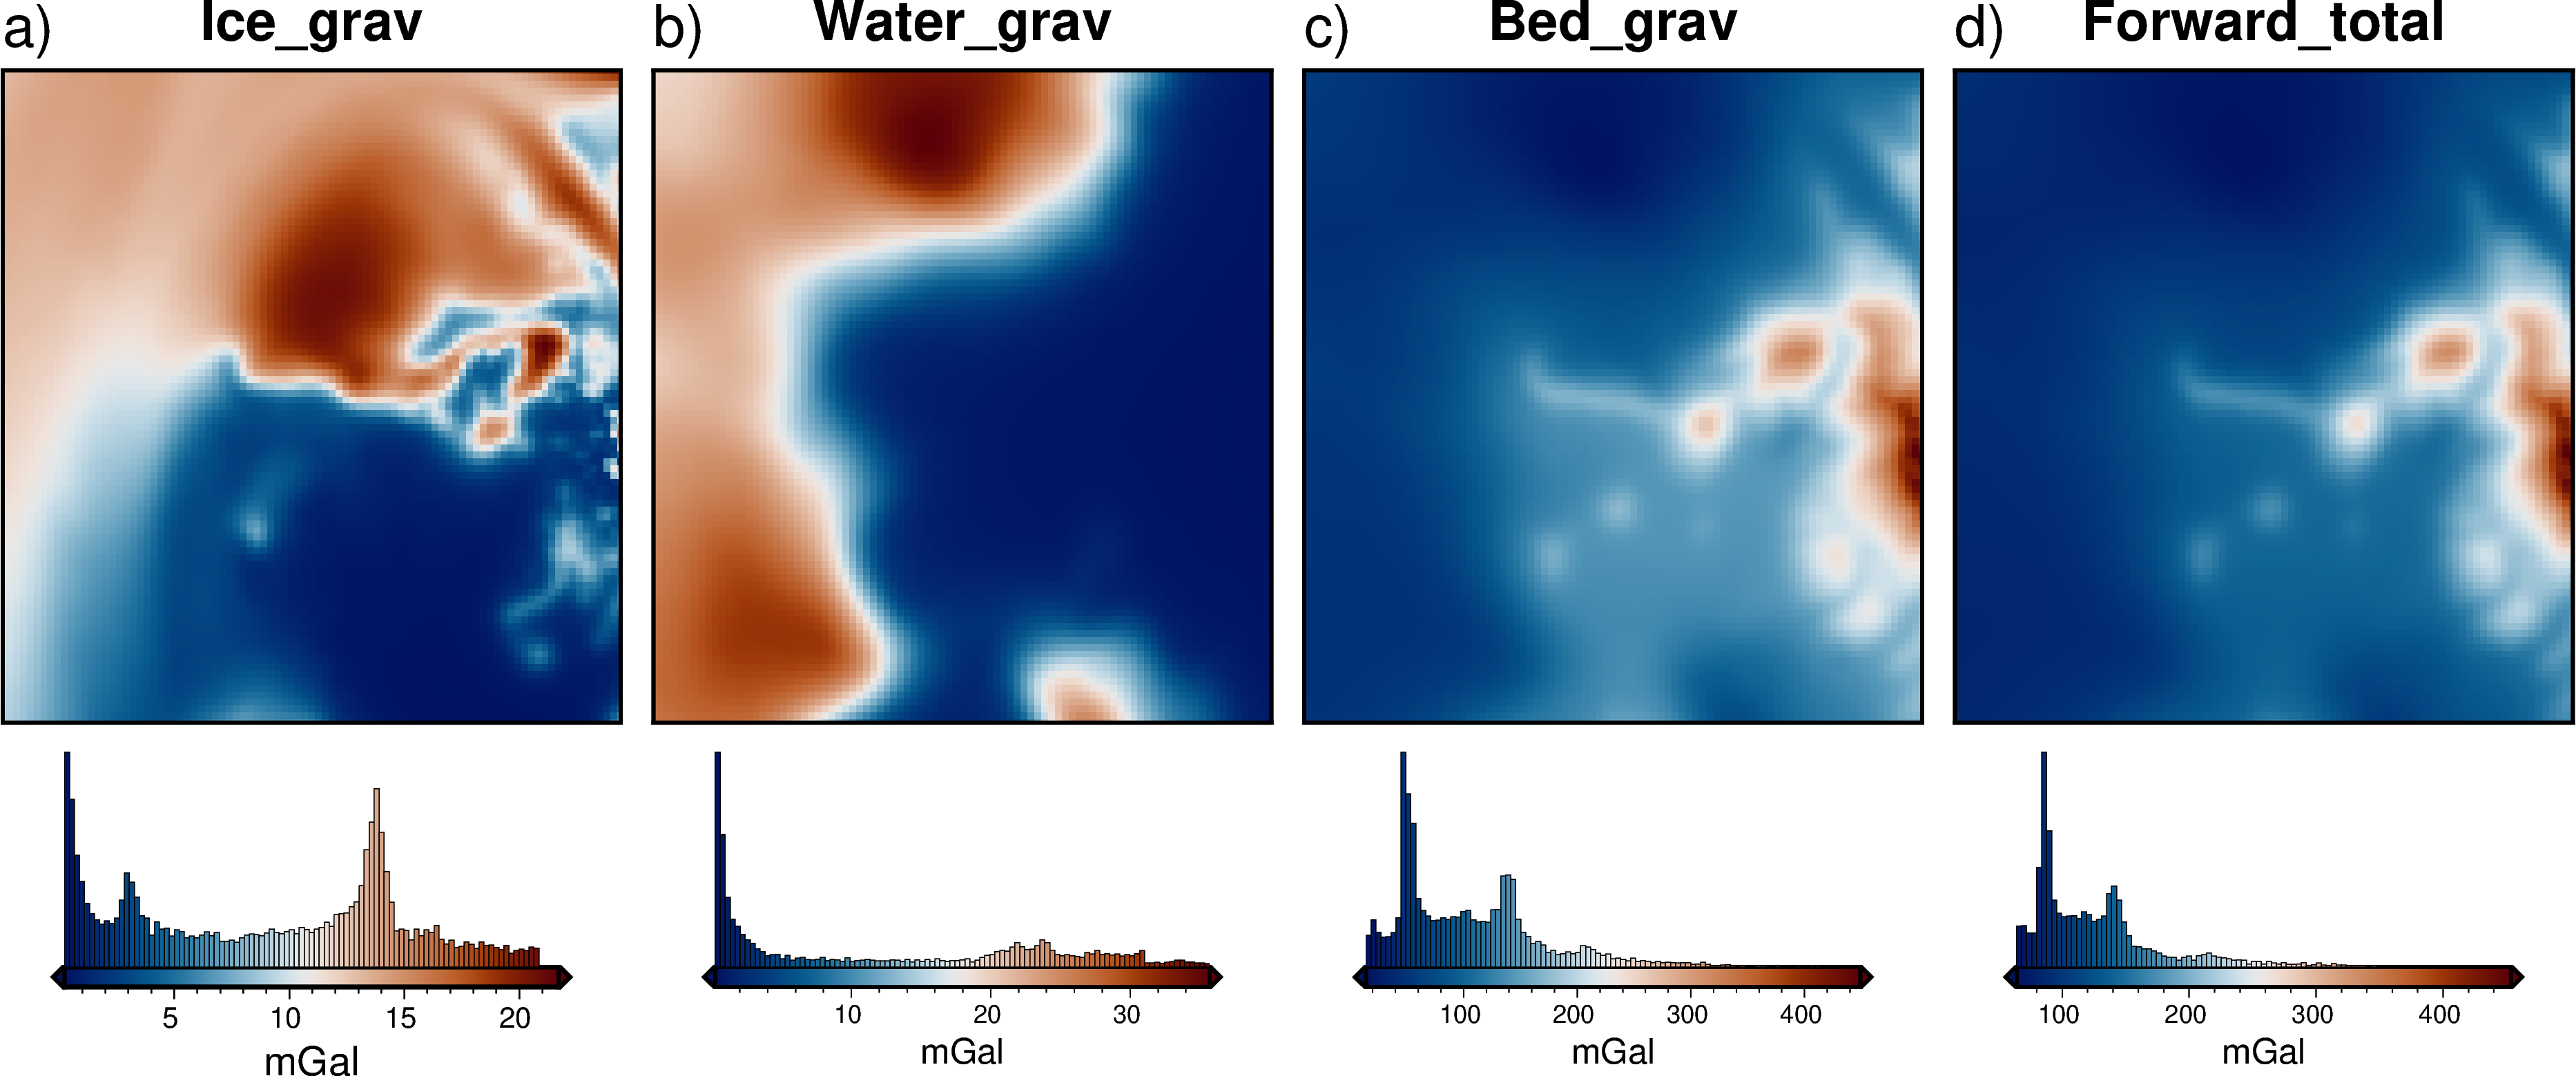

In [38]:
forward_absolute, df_absolute = inv_utils.forward_grav_of_prismlayer(
    [ice_prisms, water_prisms, earth_prisms],
    observation_points,
    plot=True,
    names=["ice_grav", "water_grav", "bed_grav"],
    # remove_mean=True,
    progressbar=True,
)

In [39]:
df_absolute

,northing,easting,upward,ice_grav,water_grav,bed_grav,forward_total
0,-1310000.0,210000.0,3000.0,9.176772,26.747756,49.217260,85.141788
1,-1310000.0,212000.0,3000.0,8.968201,26.861343,49.511326,85.340870
2,-1310000.0,214000.0,3000.0,8.733963,26.971970,49.882246,85.588180
3,-1310000.0,216000.0,3000.0,8.458908,27.093444,50.331863,85.884216
4,-1310000.0,218000.0,3000.0,8.142112,27.226702,50.860443,86.229257
...,...,...,...,...,...,...,...
8731,-1120000.0,382000.0,3000.0,18.858836,0.888985,98.130171,117.877992
8732,-1120000.0,384000.0,3000.0,19.309169,0.786475,98.242759,118.338403
8733,-1120000.0,386000.0,3000.0,19.735660,0.699173,98.647908,119.082742
8734,-1120000.0,388000.0,3000.0,20.054847,0.625200,99.647271,120.327319


In [40]:
df_absolute["terrain_mass_effect"] = (
    df_absolute.ice_grav + df_absolute.water_grav + df_absolute.bed_grav
)
df_absolute

,northing,easting,upward,ice_grav,water_grav,bed_grav,forward_total,terrain_mass_effect
0,-1310000.0,210000.0,3000.0,9.176772,26.747756,49.217260,85.141788,85.141788
1,-1310000.0,212000.0,3000.0,8.968201,26.861343,49.511326,85.340870,85.340870
2,-1310000.0,214000.0,3000.0,8.733963,26.971970,49.882246,85.588180,85.588180
3,-1310000.0,216000.0,3000.0,8.458908,27.093444,50.331863,85.884216,85.884216
4,-1310000.0,218000.0,3000.0,8.142112,27.226702,50.860443,86.229257,86.229257
...,...,...,...,...,...,...,...,...
8731,-1120000.0,382000.0,3000.0,18.858836,0.888985,98.130171,117.877992,117.877992
8732,-1120000.0,384000.0,3000.0,19.309169,0.786475,98.242759,118.338403,118.338403
8733,-1120000.0,386000.0,3000.0,19.735660,0.699173,98.647908,119.082742,119.082742
8734,-1120000.0,388000.0,3000.0,20.054847,0.625200,99.647271,120.327319,120.327319


## Proper terrain mass effect

In [41]:
ice_surface_prisms = inv_utils.grids_to_prisms(
    surface=surface,
    reference=0,
    density=xr.where(
        surface >= 0,
        917 - 1,
        1 - 917,
    ),
    input_coord_names=["x", "y"],
)

water_surface_prisms = inv_utils.grids_to_prisms(
    surface=icebase,
    reference=0,
    density=xr.where(
        icebase >= 0,
        1030 - 917,
        917 - 1030,
    ),
    input_coord_names=["x", "y"],
)

bed_prisms = inv_utils.grids_to_prisms(
    surface=bed,
    reference=0,
    density=xr.where(
        bed >= 0,
        2670 - 1030,
        1030 - 2670,
    ),
    input_coord_names=["x", "y"],
)


# plotting.show_prism_layers(
#     [surface_prisms, bed_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     # color_by='constant',
#     clip_box=False,
#     zscale=20,
# )

  0%|                                                  | 0/8736 [00:00<?, ?it/s]

  0%|                                                  | 0/8736 [00:00<?, ?it/s]

  0%|                                                  | 0/8736 [00:00<?, ?it/s]

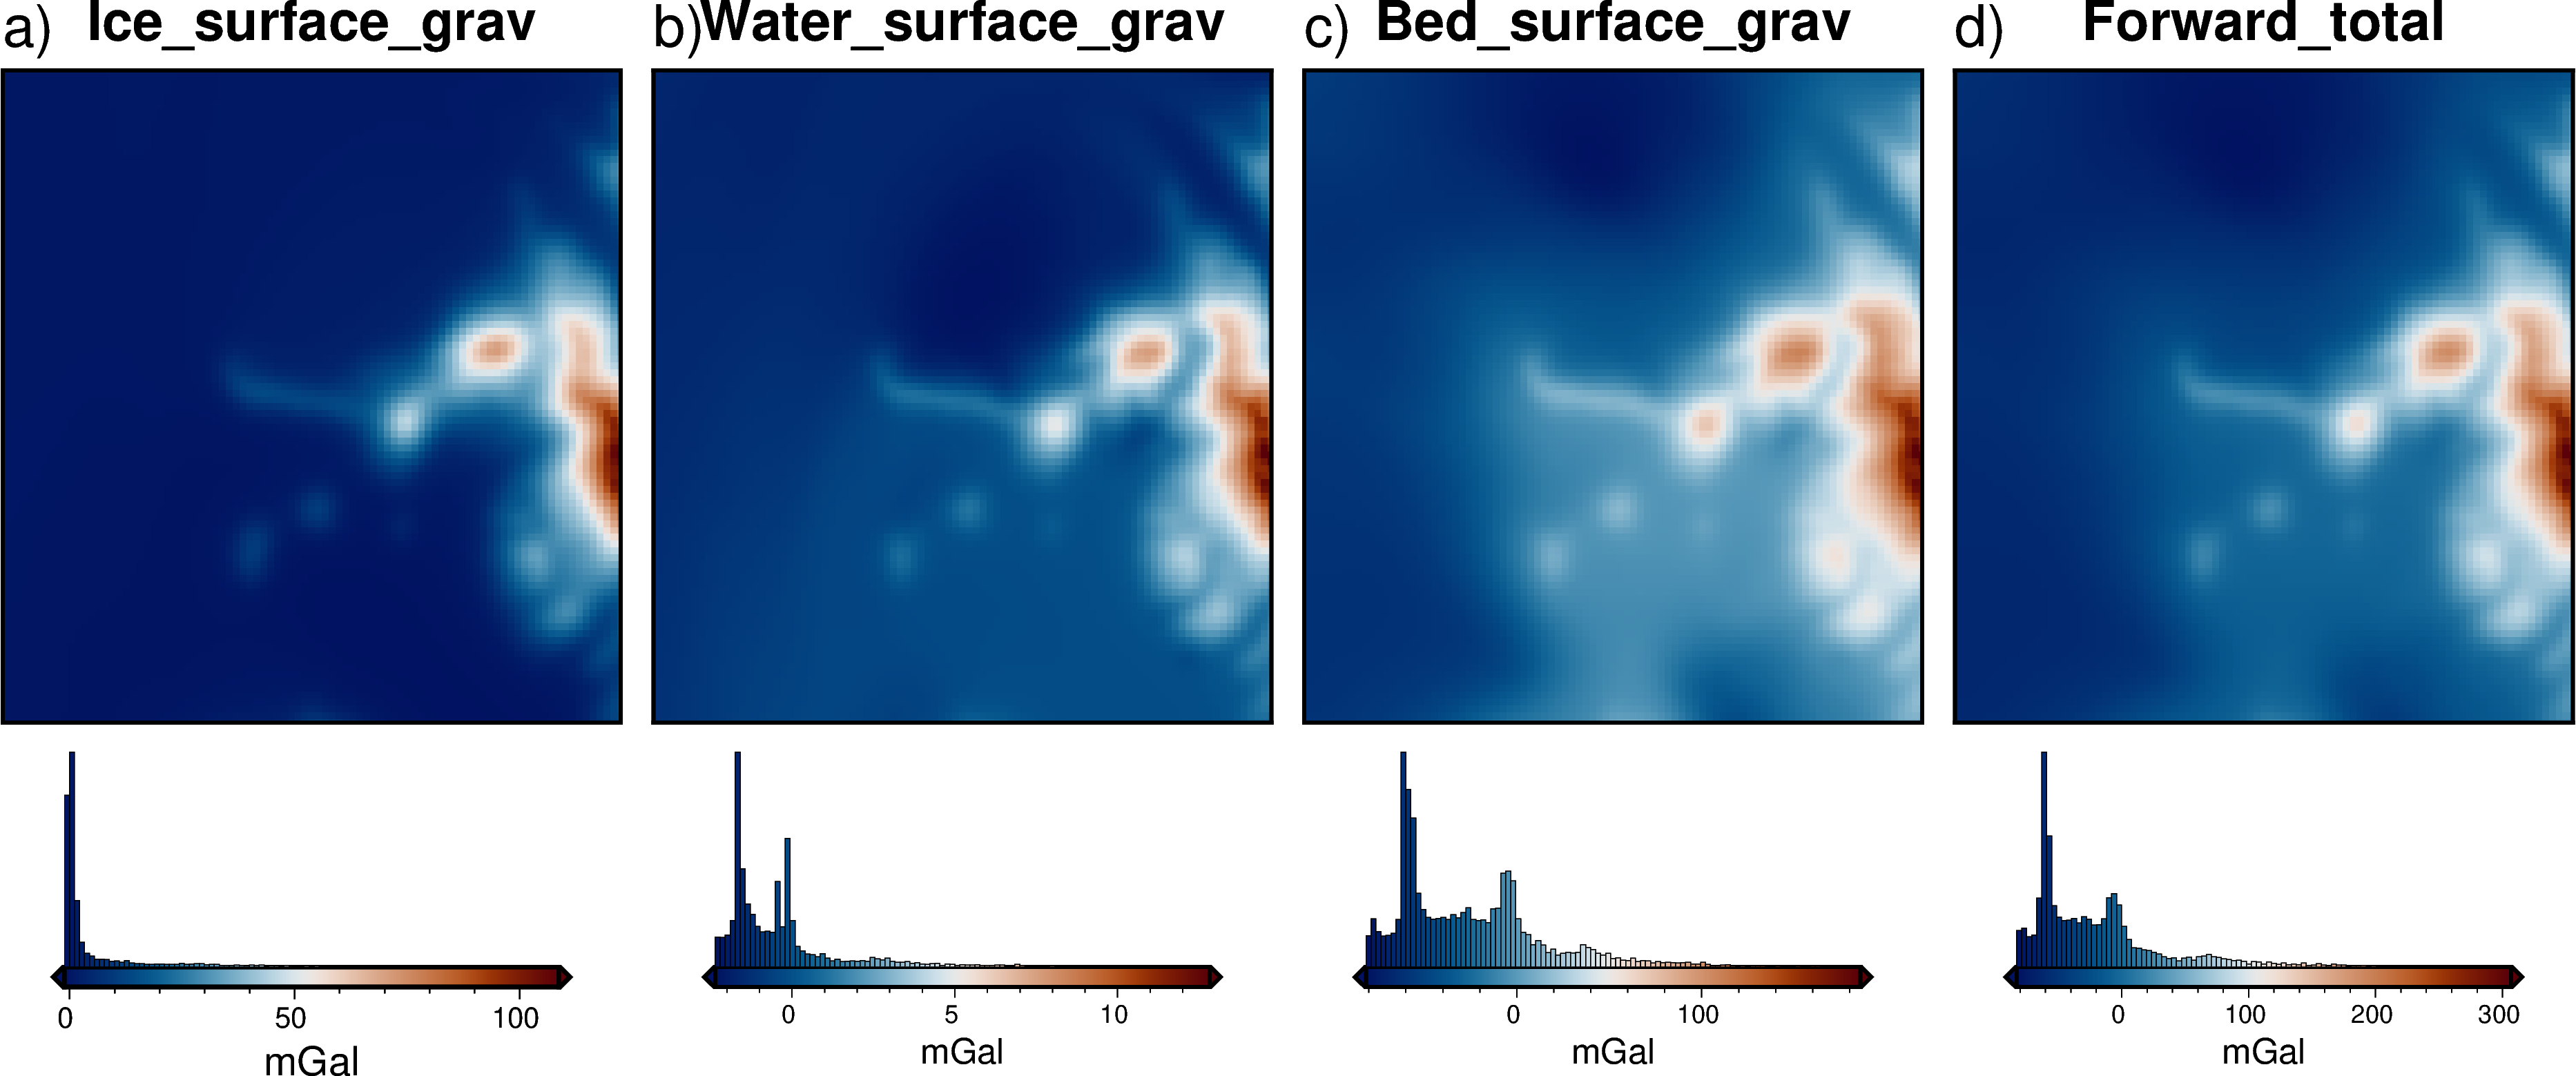

In [42]:
proper, df_proper = inv_utils.forward_grav_of_prismlayer(
    [ice_surface_prisms, water_surface_prisms, bed_prisms],
    observation_points,
    plot=True,
    names=["ice_surface_grav", "water_surface_grav", "bed_surface_grav"],
    # remove_mean=True,
    progressbar=True,
)

In [43]:
df_proper["terrain_mass_effect"] = (
    df_proper.ice_surface_grav
    + df_proper.water_surface_grav
    + df_proper.bed_surface_grav
)
df_proper

,northing,easting,upward,ice_surface_grav,water_surface_grav,bed_surface_grav,forward_total,terrain_mass_effect
0,-1310000.0,210000.0,3000.0,-0.323168,-1.170701,-59.579369,-61.073239,-61.073239
1,-1310000.0,212000.0,3000.0,-0.338378,-1.146876,-59.414440,-60.899693,-60.899693
2,-1310000.0,214000.0,3000.0,-0.355060,-1.120069,-59.201531,-60.676660,-60.676660
3,-1310000.0,216000.0,3000.0,-0.375462,-1.088692,-58.939554,-60.403707,-60.403707
4,-1310000.0,218000.0,3000.0,-0.399604,-1.052632,-58.628387,-60.080623,-60.080623
...,...,...,...,...,...,...,...,...
8731,-1120000.0,382000.0,3000.0,3.099644,-1.941555,-29.593797,-28.435708,-28.435708
8732,-1120000.0,384000.0,3000.0,3.504489,-1.947106,-29.511139,-27.953756,-27.953756
8733,-1120000.0,386000.0,3000.0,3.999798,-1.938559,-29.248091,-27.186852,-27.186852
8734,-1120000.0,388000.0,3000.0,4.604039,-1.903352,-28.619327,-25.918639,-25.918639


## Compare forward gravities

In [44]:
plot_type = "xarray"
# plot_type = 'pygmt'

In [59]:
proper_effect = (
    df_proper.set_index(["northing", "easting"]).to_xarray().terrain_mass_effect
)
absolute_effect = (
    df_absolute.set_index(["northing", "easting"]).to_xarray().terrain_mass_effect
)

offset = np.nanmedian(proper_effect - absolute_effect)

absolute_centered = absolute_effect + offset

# dif = grav_grids.terrain_effect - stripping_centered

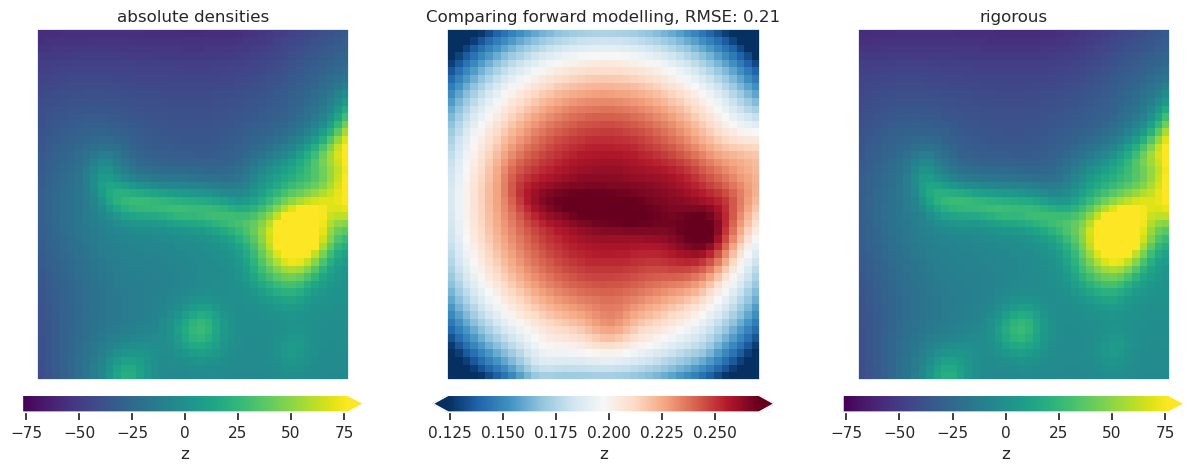

In [61]:
grids = utils.grd_compare(
    absolute_centered,
    proper_effect,
    region=vd.pad_region(inner_region, -50e3),
    plot=True,
    grid1_name="absolute densities",
    grid2_name="rigorous",
    title="Comparing forward modelling",
    # diff_maxabs=50,
    robust=True,
    hist=True,
    plot_type=plot_type,
)

In [62]:
data_grids = [absolute_centered, proper_effect]
data_names = [
    "Stripping terrain effect",
    "Terrain effect",
]
data_dict = profile.make_data_dict(
    names=data_names,
    grids=data_grids,
    colors=[
        "black",
        "red",
    ],
    # axes = [0,0,0,1]
)

layer_names = [
    "ice",
    "water",
    "earth",
]
layer_colors = [
    "lightskyblue",
    "darkblue",
    "lightbrown",
]
layer_grids = [surface, icebase, bed]

layers_dict = profile.make_data_dict(
    names=layer_names,
    grids=layer_grids,
    colors=layer_colors,
)

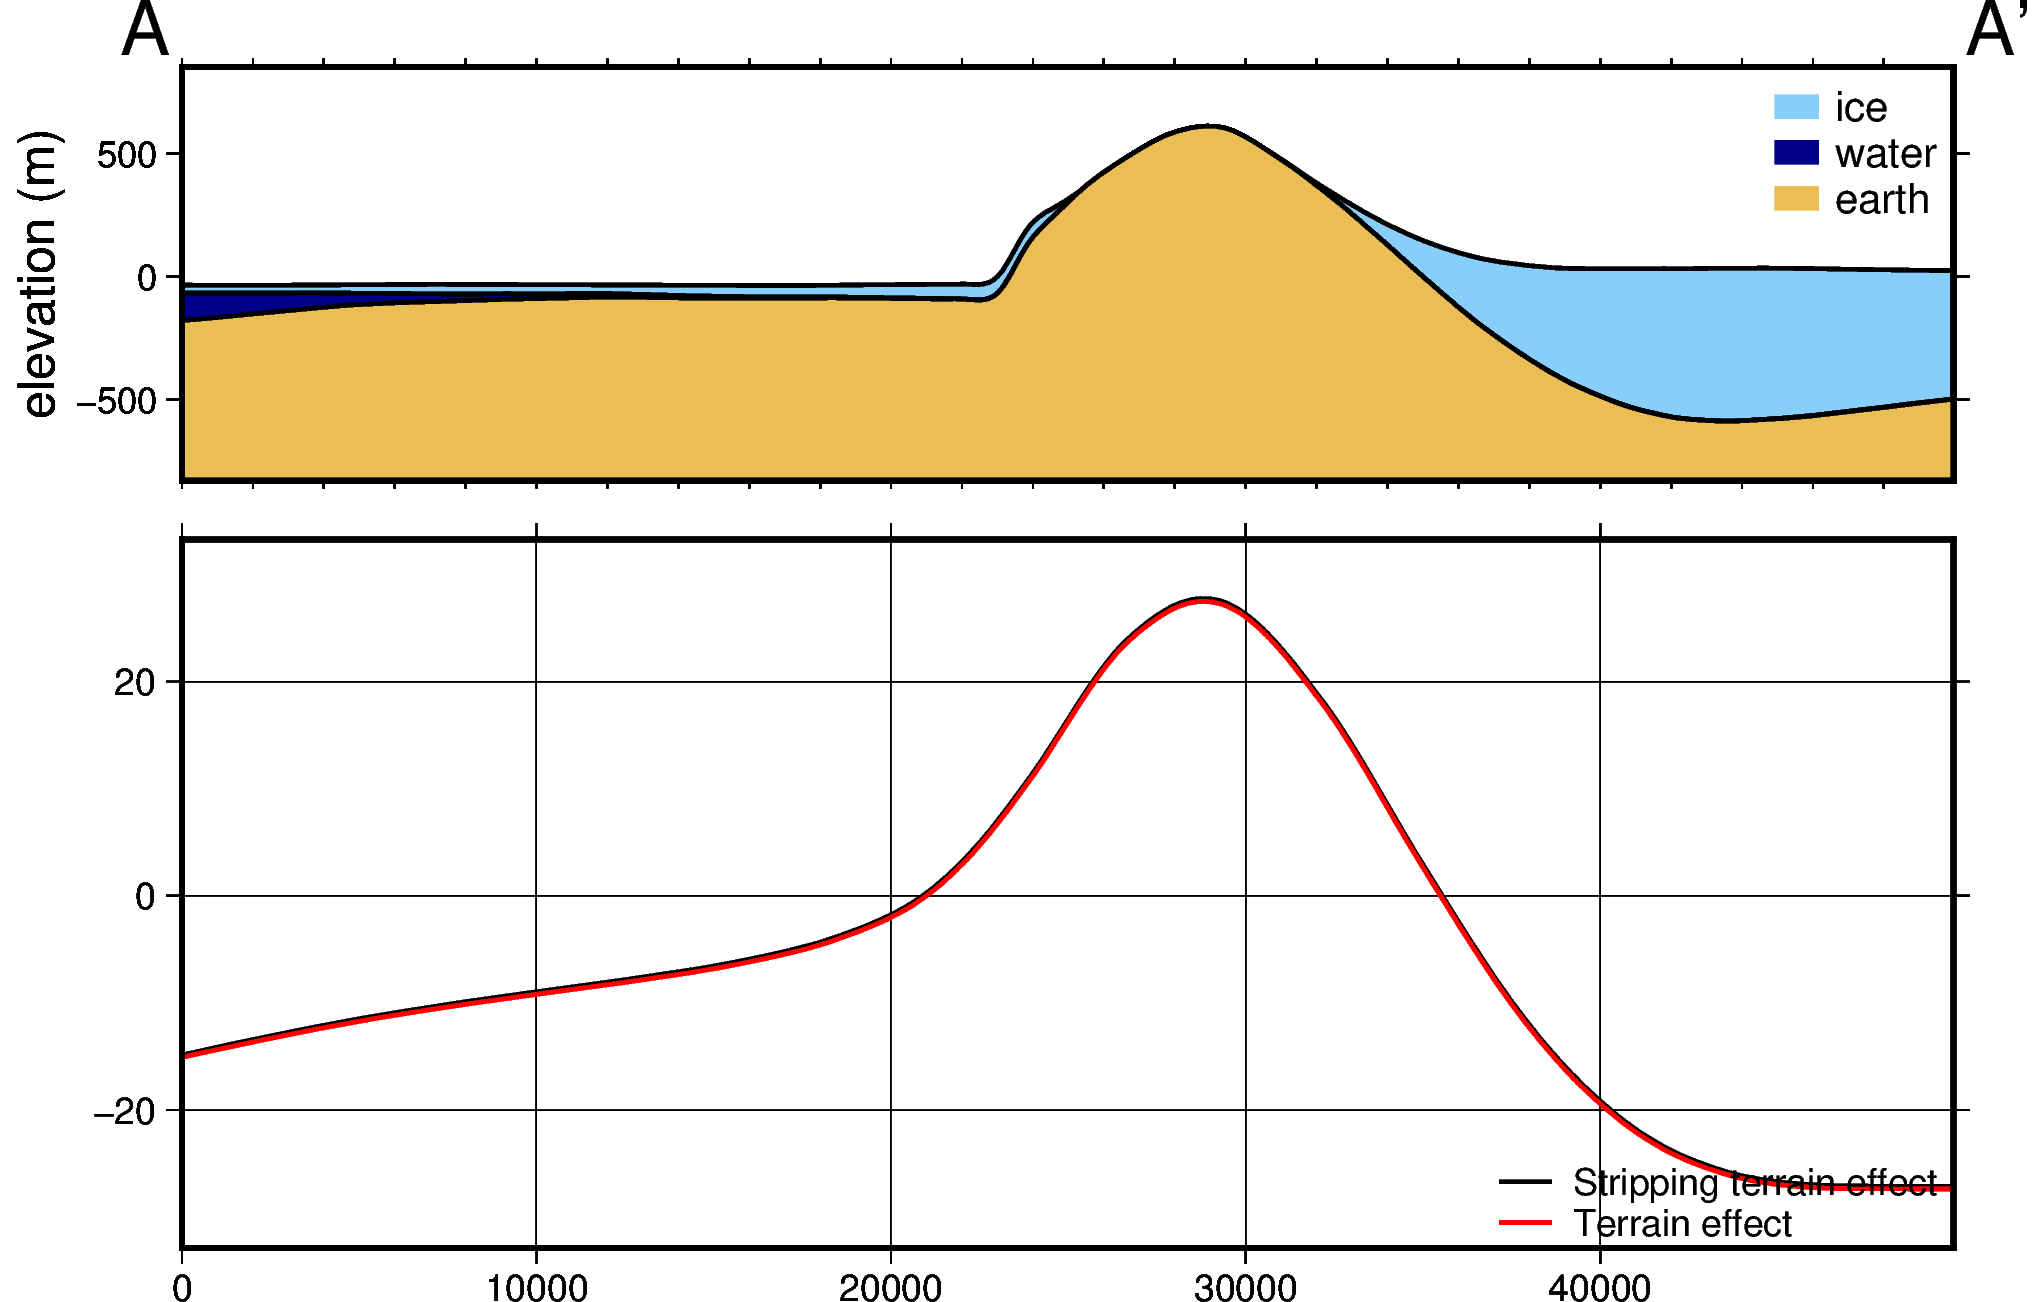

In [64]:
fig, df_layers, df_data = profile.plot_profile(
    "points",
    start=(inner_region[0], inner_region[2]),
    stop=(inner_region[1], inner_region[3]),
    num=10000,
    min_dist=100e3,
    max_dist=150e3,
    clip=True,
    data_height=6,
    fig_height=10,
    fig_width=15,
    data_dict=data_dict,
    data_legend_loc="jBR+o0c/-.1c",  # "jBL+jTL+o0c/.4c",
    # data_buffer=.1,
    # data_frame=["neSW", "ya+lgravity (mGal)", "xag+lDistance (m)"],
    # data_pen_style=[None,None,".", None],
    share_yaxis=True,
    layers_dict=layers_dict,
    layers_legend=True,
    layer_buffer=0.2,
    layers_legend_loc="jTR",
    # layers_legend_box="+gwhite",
    # layers_legend_scale=.5,
    # layers_pen_thickness=[1.5,1.5,1.5,.6, .6],
    layers_pen_color="black",
    # layers_pen_style=[None,None,None,"-."],
    # layer_transparency=[40,40,30,100,100],
    layers_frame=["nesW", "ya+lelevation (m)", "xf"],
    start_label="A",
    end_label="A' ",
)
fig.show()

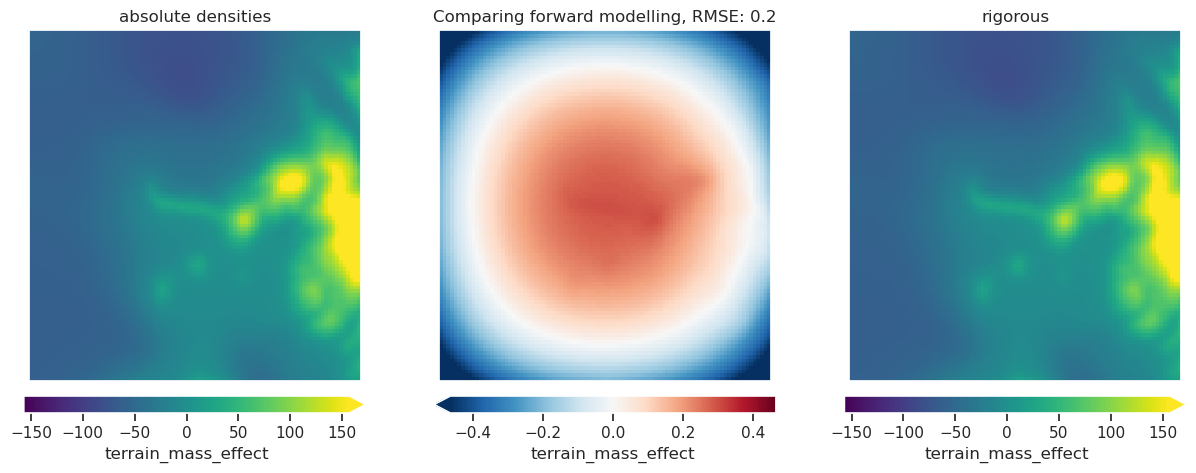

In [53]:
grids = utils.grd_compare(
    absolute_centered,
    proper_effect,
    # region=vd.pad_region(inner_region, 70e3),
    plot=True,
    grid1_name="absolute densities",
    grid2_name="rigorous",
    title="Comparing forward modelling",
    # diff_maxabs=50,
    robust=True,
    hist=True,
    plot_type=plot_type,
)

## Density contrasts

In [10]:
density_contrast = 917 - 1
zref = np.nanmean(surface)
density = xr.where(surface >= zref, density_contrast, -density_contrast)

surface_prisms = inv_utils.grids_to_prisms(
    surface,
    zref,
    density=density,
    input_coord_names=["x", "y"],
)


density_contrast = 1030 - 917
zref = np.nanmean(icebase)
density = xr.where(icebase >= zref, density_contrast, -density_contrast)

icebase_prisms = inv_utils.grids_to_prisms(
    icebase,
    zref,
    density=density,
    input_coord_names=["x", "y"],
)

density_contrast = 2670 - 1030
zref = np.nanmean(bed)
density = xr.where(bed >= zref, density_contrast, -density_contrast)

bed_prisms = inv_utils.grids_to_prisms(
    bed,
    zref,
    density=density,
    input_coord_names=["x", "y"],
)

# plotting.show_prism_layers(
#     [surface_prisms, bed_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     # color_by='constant',
#     clip_box=False,
#     zscale=20,
# )

  0%|                                                  | 0/8736 [00:00<?, ?it/s]

  0%|                                                  | 0/8736 [00:00<?, ?it/s]

  0%|                                                  | 0/8736 [00:00<?, ?it/s]

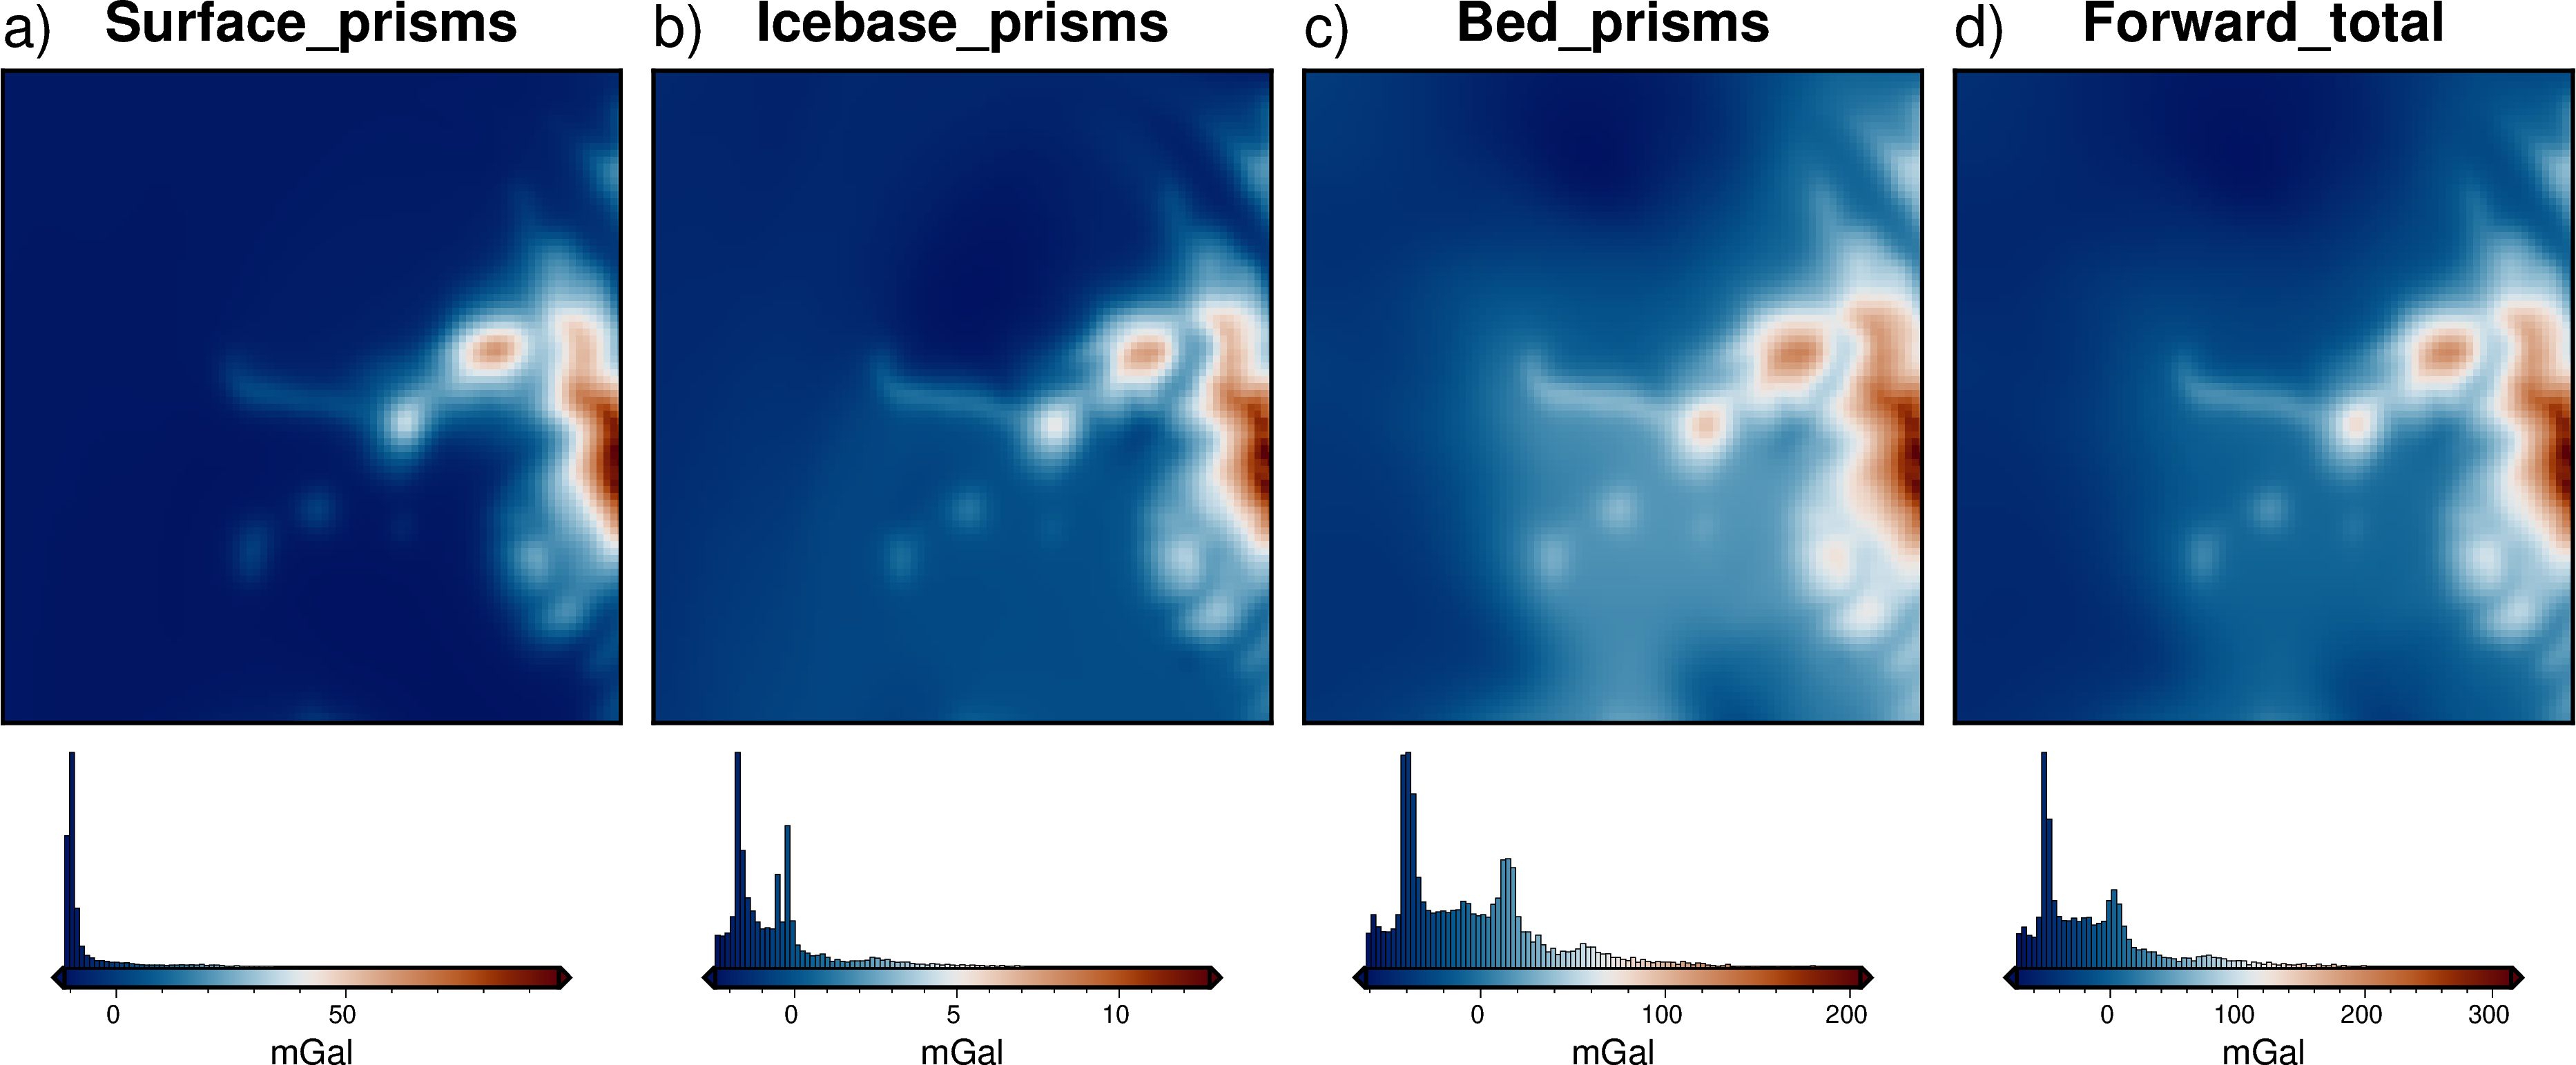

In [11]:
contrasts, df = inv_utils.forward_grav_of_prismlayer(
    [surface_prisms, icebase_prisms, bed_prisms],
    observation_points,
    plot=True,
    names=["surface_prisms", "icebase_prisms", "bed_prisms"],
    # remove_mean=True,
    progressbar=True,
)

## Compare forward gravities

In [12]:
plot_type = "xarray"
# plot_type = 'pygmt'

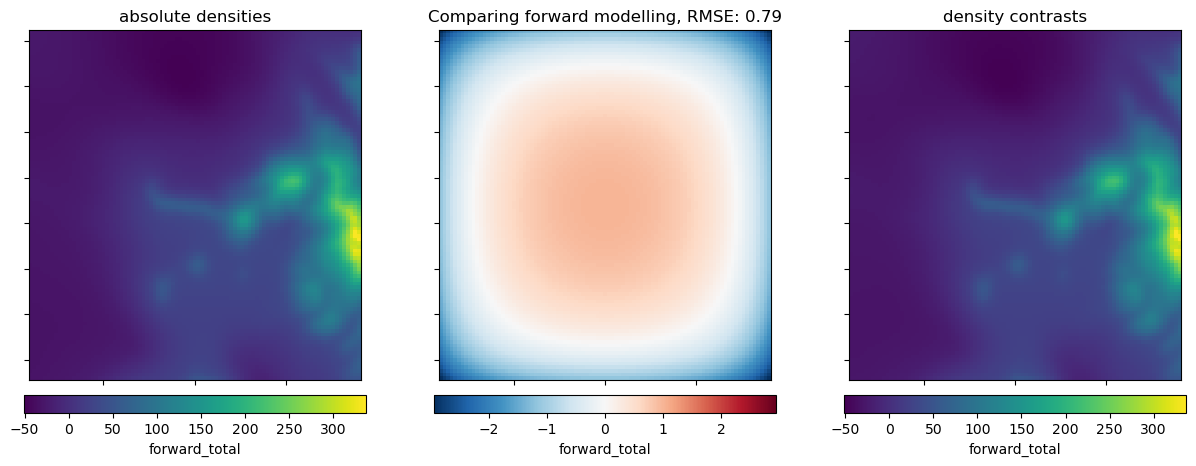

In [15]:
grids = utils.grd_compare(
    forward_absolute.forward_total - np.nanmedian(forward_absolute.forward_total),
    contrasts.forward_total - np.nanmedian(contrasts.forward_total),
    plot=True,
    grid1_name="absolute densities",
    grid2_name="density contrasts",
    title="Comparing forward modelling",
    # diff_maxabs=50,
    hist=True,
    plot_type=plot_type,
)